# PH554 end-semester exam

For each of the following problems, ~20-30% of the assigned marks will be reserved for evaluating the presentation of your work, e.g. tables and plots, annotation inside the coding blocks, markdown segments to describe your work, etc. Be explicit about all the relevant steps. And of course, your codes should run without bugs!

#### Remember to include a code of conduct preamble in your submission.

#### All the best!

- Name: Siddhant Midha
- Roll no.: 200070078
- *Declaration*. I have adhered to the academic code of conduct and will do so in the future as well.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
from numpy import sqrt, pi, exp
plt.rcParams.update({'font.size': 22 })
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from scipy.sparse import csr_matrix
from qutip import *
import scipy
import random
from joblib import Parallel, delayed


## Problem 1: (10 marks)

Let there be a single spin-$\frac{1}{2}$ in a magnetic field, i.e. $H = \mathbf{B} \cdot \hat{\mathbf{S}}$.
Usually there are additional factors of $\hbar$, Lande g-factor and Bohr magneton, but we will assume that they 
are clubbed into $\mathbf{B}$. Furthermore, take the magnetic field to be in the z-direction, 
i.e. $H = B \; \hat{S^z}$ without loss of generality.

Analytically, write out the expression for the average energy and  magnetization of the spin as a function of temperature. (1) Take the Boltzmann constant $k_B = 1$.

Now, set up a Monte Carlo simulation with the Metropolis scheme to compute the average energy and magnetization. (4)

Plot the auto-correlation of magnetization and energy and estimate the number of Monte Carlo steps by which these measurements get decorrelated. (2)


Plot the average energy and magnetization both using the analytical expression and from the Monte Carlo simulations and show their agreement for a range of temperatures (3). You can take warm-up of around 10000 steps.


We have,
$$\mathcal{H} = B \hat{S}_z= B \begin{pmatrix}1 & 0 \\ 0 & -1 \end{pmatrix}$$
in the basis
$$|{1/2}\rangle = \begin{pmatrix}1 \\ 0\end{pmatrix}, |{-1/2}\rangle = \begin{pmatrix}0 \\ 1\end{pmatrix}$$

which has the eigenspectrum,
$$\mathcal{H}|E_{\pm}\rangle = E_{\pm}|E_{\pm}\rangle$$
with $$E_{\pm} = \pm B$$ and 
Now,
$$\langle E\rangle = \frac{\sum_i E_ie^{-\beta E_i}}{\sum_i e^{-\beta E_i}} = \frac{Be^{-\beta B} + (-B)e^{\beta B}}{e^{-\beta B} + e^{\beta B}}$$
Furthermore,
$$\langle m\rangle = \frac{(1/2)e^{-\beta B} + (-1/2)e^{\beta B}}{e^{-\beta B} + e^{\beta B}}$$

In [56]:
sz = np.array([[1,0],[0,-1]])
B = 1 
H = B * sz 

def analytical_energy(B=1,T=1):
    beta = 1/T 
    return (B * exp(-beta*B) - B * exp(beta * B)) / (exp(-beta*B) + exp(beta * B))

def analytical_magnet(B=1,T=1):
    beta = 1/T 
    return ((1/2) * exp(-beta*B) - (1/2) * exp(beta * B)) / (exp(-beta*B) + exp(beta * B))

def return_mc2D(B=1,T=1,ITER=50000,start=1,pself=0):
    '''
    B = magnetic field value
    ITER = total number of iterations AFTER warm up
    start = start state \in \{+1,-1\} which to start with
    '''
    INIT_TIME = 10000 #warm up time 

    beta = 1/T # beta = 1/(kBT), kB=1
    config = start  # initialize the config \in \{+-1\}

    # returning arrays
    mz_arr = []
    energy_arr = []
    
    # main loop
    for idx in (range(ITER+INIT_TIME+1)):
        energy = config * B
        
        if idx > INIT_TIME: # store values AFTER the warmup time
            energy_arr.append(energy)
            mz = config / 2 
            mz_arr.append(mz)

        u1 = np.random.uniform() # first check for self-loop with probability pself
        if u1 < pself: #self loop with probability pself
            pass 
        else: #normal Metropolis Hastings with probability 1-pself
            # propose to flip 

            newconfig = -1 * config 

            newenergy = B * newconfig 

            if newenergy < energy:  # case1: accept proposal
                config = np.copy(newconfig) 
            
            elif newenergy > energy: # case2: accept with some prob 
                delta = - energy + newenergy
                prob = np.exp(-delta * beta)
                u2 = np.random.uniform()
                if u2 < prob: # sub-case
                    config = np.copy(newconfig) 

    return np.array(energy_arr), np.array(mz_arr)


def compute_autocorr(mz_arr,DeltaRange=300):
    # compute the autocorrelation function
    q_arr = np.copy(mz_arr)
    POSTINIT = len(mz_arr)
    q_av = np.mean(q_arr) #total average, used to compute fluctuations
    Delta_arr = np.array(range(DeltaRange))
    aq_av_num = np.zeros(len(Delta_arr)) #numerator container
    aq_av_den = np.zeros(len(Delta_arr)) #denominator container

    for idx in tqdm(range(POSTINIT-DeltaRange-1)): #average over the index idx

        for Delta in Delta_arr:
            aq_av_num[Delta] += (q_arr[idx] - q_av) * (q_arr[idx + Delta] - q_av)
            aq_av_den[Delta] += (q_arr[idx] - q_av) ** 2

    aq_av = aq_av_num / aq_av_den # get the division right to normalize properly
    return aq_av 


Before we move ahead, note that this is a two-state Markov chain. The issue here can be illustrated with an example: consider a transition matrix with action
$$T_{0\to 1} = T_{1\to 0} = 1$$
but _no_ self loops. This has the steady distribution $p^* = (1/2,1/2)$ but if we start from $x^0 = 0 (1)$ we will _always_ keep on oscillating. More precisely, self-loops are important for ergodicity. Thus, we add a self-loop on our Markov chain with probability $p_{self} \ll 1$, and show that this improves the MCMC averages, as shown in two simple cases below.

In [43]:
T0 = 0.5
B0 = 1 
energy_arr, mz_arr = return_mc2D(B=B0,T=T0,ITER=20000,start=-1,pself=0) 
np.mean(energy_arr),analytical_energy(B=B0,T=T0)

(-0.9619, -0.964027580075817)

In [44]:
T0 = 0.5
B0 = 1 
energy_arr, mz_arr = return_mc2D(B=B0,T=T0,ITER=20000,start=-1,pself=1e-6) 
np.mean(energy_arr),analytical_energy(B=B0,T=T0)

(-0.9641, -0.964027580075817)

We can always turn off the additional feature of $p_{self}$ by just ommiting the argument as the default value is zero.

100%|██████████| 9959/9959 [00:00<00:00, 26059.96it/s]


Text(0, 0.5, '$A_{|m_z,E|}(\\Delta)$')

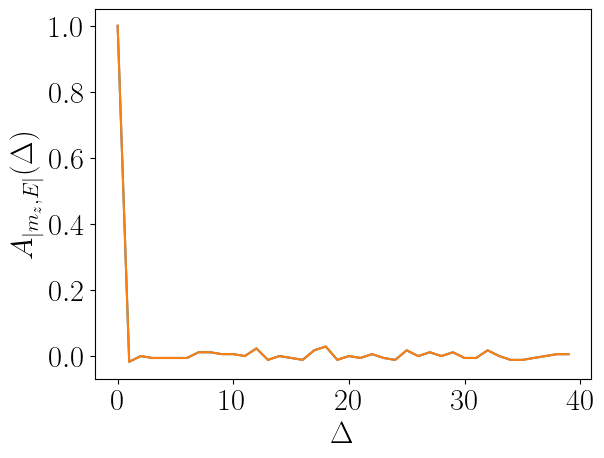

In [58]:
T0 = 0.5
B0 = 1 
energy_arr, mz_arr = return_mc2D(B=B0,T=T0,ITER=10000,start=1,pself=1e-6) 

plt.plot(compute_autocorr(energy_arr,DeltaRange=40))
plt.plot(compute_autocorr(mz_arr,DeltaRange=40))
plt.xlabel(r'$\Delta$')
plt.ylabel(r'$A_{|m_z,E|}(\Delta)$')


Thus, the samples become independent after very small (3-4) number of steps.

Now, let us compare the MCMC and the analytical results.

  0%|          | 0/50 [00:00<?, ?it/s]/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_8391/3398797711.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  beta = 1/T # beta = 1/(kBT), kB=1
/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_8391/3398797711.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  beta = 1/T
/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_8391/3398797711.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return (B * exp(-beta*B) - B * exp(beta * B)) / (exp(-beta*B) + exp(beta * B))
100%|██████████| 50/50 [00:05<00:00,  9.68it/s]


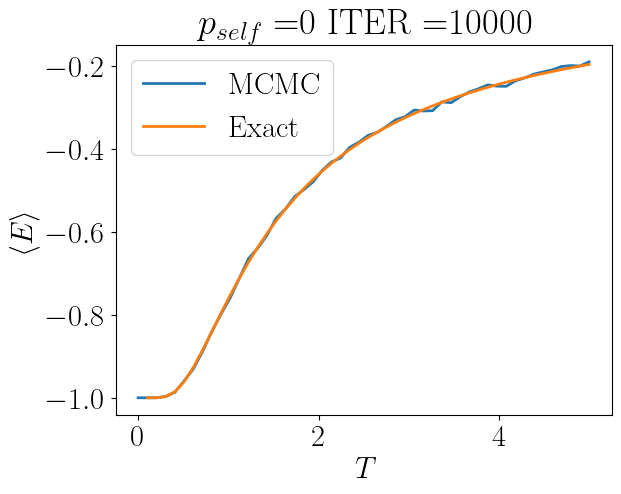

In [70]:
T0_arr = np.linspace(0,5,50)
B0 = 1 
pself = 0
ITER = 10000
MCMC_answer = []
exact_answer = []

for T0 in tqdm(T0_arr):
    energy_arr, mz_arr = return_mc2D(B=B0,T=T0,ITER=ITER,start=-1,pself=pself) 
    MCMC_answer.append(np.mean(energy_arr))
    exact_answer.append(analytical_energy(B=B0,T=T0))


plt.plot(T0_arr,MCMC_answer,linewidth=2,label='MCMC')
plt.plot(T0_arr,exact_answer,linewidth=2,label='Exact')
plt.xlabel(r'$T$')
plt.ylabel(r'$\langle E\rangle$')
plt.title('$p_{self}=$' + str(pself) + r' ITER ='+str(ITER))
plt.legend()

Works! Also, let's try for small number of ```ITER```, and vary $p_{self}$ to see how it improves, for the sake of curiosity.

  0%|          | 0/50 [00:00<?, ?it/s]/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_8391/3398797711.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  beta = 1/T # beta = 1/(kBT), kB=1
/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_8391/3398797711.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  beta = 1/T
/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_8391/3398797711.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return (B * exp(-beta*B) - B * exp(beta * B)) / (exp(-beta*B) + exp(beta * B))
100%|██████████| 50/50 [00:02<00:00, 19.08it/s]


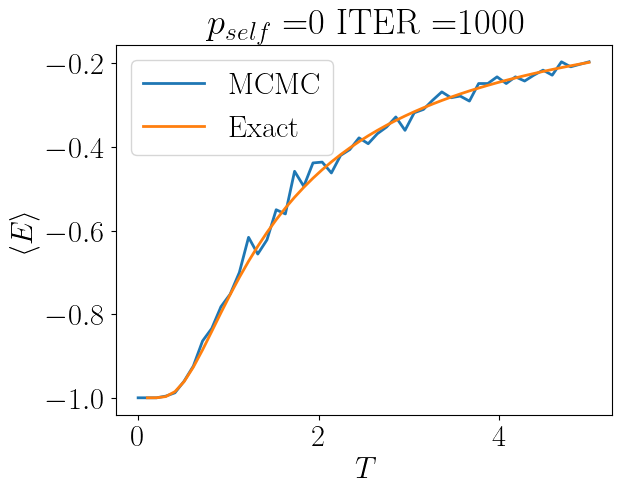

In [68]:
T0_arr = np.linspace(0,5,50)
B0 = 1 
pself = 0
ITER = 1000
MCMC_answer = []
exact_answer = []

for T0 in tqdm(T0_arr):
    energy_arr, mz_arr = return_mc2D(B=B0,T=T0,ITER=ITER,start=-1,pself=pself) 
    MCMC_answer.append(np.mean(energy_arr))
    exact_answer.append(analytical_energy(B=B0,T=T0))


plt.plot(T0_arr,MCMC_answer,linewidth=2,label='MCMC')
plt.plot(T0_arr,exact_answer,linewidth=2,label='Exact')
plt.xlabel(r'$T$')
plt.ylabel(r'$\langle E\rangle$')
plt.title('$p_{self}=$' + str(pself) + r' ITER ='+str(ITER))
plt.legend()

  0%|          | 0/50 [00:00<?, ?it/s]/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_8391/3398797711.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  beta = 1/T # beta = 1/(kBT), kB=1
/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_8391/3398797711.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  beta = 1/T
/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_8391/3398797711.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return (B * exp(-beta*B) - B * exp(beta * B)) / (exp(-beta*B) + exp(beta * B))
100%|██████████| 50/50 [00:02<00:00, 19.38it/s]


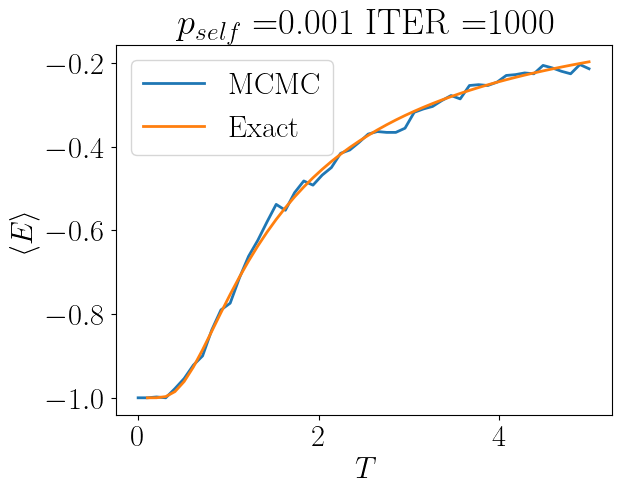

In [69]:
T0_arr = np.linspace(0,5,50)
B0 = 1 
pself = 1e-3
ITER = 1000
MCMC_answer = []
exact_answer = []

for T0 in tqdm(T0_arr):
    energy_arr, mz_arr = return_mc2D(B=B0,T=T0,ITER=ITER,start=-1,pself=pself) 
    MCMC_answer.append(np.mean(energy_arr))
    exact_answer.append(analytical_energy(B=B0,T=T0))


plt.plot(T0_arr,MCMC_answer,linewidth=2,label='MCMC')
plt.plot(T0_arr,exact_answer,linewidth=2,label='Exact')
plt.xlabel(r'$T$')
plt.ylabel(r'$\langle E\rangle$')
plt.title('$p_{self}=$' + str(pself) + r' ITER ='+str(ITER))
plt.legend()

## Problem 2: (15 marks)

By the use of a non-local transformation, one can convert the nearest-neighbour $XY$ spin-$\frac{1}{2}$ chain into a system of non-interacting spinless fermions. This is called as Jordan-Wigner transformation after Pascual Jordan and Eugene Wigner. It goes as:

$$ \sigma^+_i = \Pi_{j<i} (-1)^{n_j} c^\dagger_i $$
$$ \sigma^-_i = \Pi_{j<i} (-1)^{n_j} c_i $$
$$ \sigma^z_i = 2 n_i - 1 $$

where $\sigma^{\pm}_i = \frac{\sigma^x_i \pm i \sigma^y_i}{2}$, $c^\dagger_i$, $c_i$ are fermion creation and destruction operators at site $i$. Note these fermions are spinless, i.e., they do not have any spin index.
$\sigma^x$, $\sigma^y$,  $\sigma^z$ are the familiar Pauli matrices.
Show that under the above transformation, the spin angular momentum algebra or commutation relations obeyed by the spin operators and fermion anticommutation algebra obeyed by the fermion operators are mutually consistent. (3)

By the use of the above transformation, show that the nearest-neighbour $XY$ spin chain

$$ H  = J \sum_{\langle i,j \rangle} \left( \sigma^x_i \sigma^x_j + \sigma^y_i \sigma^y_j \right) $$

can be converted to a system of non-interacting spinless fermion hopping on the chain


$$ H = - t \sum_{\langle i,j \rangle} \left( c^{\dagger}_i c_j + c^{\dagger}_j c_i \right) ~~~ (3) $$


What is the relation between $t$ and $J$? (1)

For a small chain (say 4 or 6 sites), compute and show the equivalence of the eigenspectrum by diagonalizing both the original $XY$ spin chain in the $M^z=0$ and $M^z=+1$ sector, and single-particle diagonalization of the fermion hopping Hamiltonian to reconstruct the $XY$ spectrum in these $M^z$ sectors. (8) Hint: It might be easier to use open boundary conditions.

Bonus: The above equivalence also goes through for periodic boundary conditions once you handle the hopping on the periodic bond carefully. Show the equivalence for periodic boundary conditions for bonus.

We know that,
$$\{c_i,c_j\} = 0 = \{c_i^{\dagger},c_j^{\dagger}\}, \{c^{\dagger}_i,c_j\} = \delta_{ij} \to (1)$$
are the fermionic canonical commutation relations (CCR). 

Also, the Pauli algebra $\{\sigma_x,\sigma_z,\sigma_y\}$ obeys the following,
$$[\sigma^i_1,\sigma^j_2] = 2\iota\delta_{ij} \sigma^j_3 \to (2)$$
where the indices $1,2,3$ can be permuted cyclically: e.g., $xyz,yzx,zxy$.


Translated to $\sigma_{\pm}$, these relations read:
$$[\sigma^i_+,\sigma^j_-] = \delta_{ij}\sigma_z \to (3)$$
Now, we will show that $(3)$ follows from $(1)$. Before we do so, note two things:

1. $\{n_i,c_i\}=1$
as $n_ic_i = c^{\dagger}_ic_ic_i = (1-c_ic_i^{\dagger}c_i) = 1 - c_in_i$
2. $[n_j,c_i]=0$ for $j \neq i$ as $n_jc_i = c^{\dagger}_jc_jc_i = -c^{\dagger}_jc_ic_j = (-)-c_ic^{\dagger}_jc_j = c_in_j$

Now consider, 
$$[\sigma^i_+,\sigma^i_-] = [\Pi_{j<i} (-1)^{n_j} c^\dagger_i,\Pi_{j<i} (-1)^{n_j} c_i]$$
$$(\Pi_{j<i} (-1)^{n_j} c^\dagger_i)(\Pi_{j<i} (-1)^{n_j} c_i) - (\Pi_{j<i} (-1)^{n_j} c_i)(\Pi_{j<i} (-1)^{n_j} c^\dagger_i)$$
Now note that since the $j$ indices are _never_ equal to $i$, the $(-1)^{n_j}$ can be moved around as numbers as everything now commutes. Thus, 
$$[\sigma^i_+,\sigma^i_-] = c_i^{\dagger}c_i - c_ic_i^{\dagger} = c_i^{\dagger}c_i - (1- c_i^{\dagger}c_i) = 2c_i^{\dagger}c_i - 1 \equiv \sigma_z$$
Now consider the different indices $k > l$,
$$[\sigma^k_+,\sigma^l_-] = [\Pi_{j<k} (-1)^{n_j} c^\dagger_k,\Pi_{j<l} (-1)^{n_j} c_l]$$
$$(\Pi_{j<k} (-1)^{n_j} c^\dagger_k)(\Pi_{j<l} (-1)^{n_j} c_l) - (\Pi_{j<l} (-1)^{n_j} c_l)(\Pi_{j<k} (-1)^{n_j} c^\dagger_k)$$
Now because of the fact that $k > l$, when we try to move the $c_{k,l}$ to the boundaries, we will pick up an extra phase which will lead to destructive interference between the two terms, and thereby cancellation. Particularly, this extra phase comes because of the fact that when the $c_l$ operator is tried to move around the string of phases up to $j < k$, it also encounters $n_l$ as $l < k$ as well. Thus, because of attaching these non-local strings, we are able to preserve the Pauli algebra (and vice-versa) within the J-W transformation.



Now, we come to 
$$ H  = J \sum_{\langle i,j \rangle} \left( \sigma^x_i \sigma^x_j + \sigma^y_i \sigma^y_j \right) $$

Note that,
$$\sigma_{\pm} := \frac{\sigma_x \pm\iota \sigma_y}{2} \implies \sigma_x = (\sigma_+ + \sigma_-),~~ \sigma_y = -\iota(\sigma_+ -\sigma_-)$$
Thus,
$$\sigma^x_i \sigma^x_j + \sigma^y_i \sigma^y_j =  (\sigma^i_+ + \sigma^i_-)(\sigma^j_+ + \sigma^j_-) - (\sigma^i_+ - \sigma^i_-)(\sigma^j_+ - \sigma^j_-)$$
$$\implies \sigma^x_i \sigma^x_j + \sigma^y_i \sigma^y_j =  2(\sigma^i_+\sigma^j_- + \sigma^i_-\sigma^j_+)$$
Now, it is easy to see that $\sigma^i_+\sigma^j_- \sim c_i^{\dagger}c_j$, and since $i-j = 1$, picks up a minus sign. Thus, it gets transformed, under the JW mapping, to
$$ H = - t \sum_{\langle i,j \rangle} \left( c^{\dagger}_i c_j + c^{\dagger}_j c_i \right) ~~~ (3) $$
with $t=2J$.

In [146]:
def create_statedict(L):
    d = 2 #local Hilbert space dimension
    D = int(d ** L) #total Hilbert space direction
    states_dict = {}
    for i in range((D)):
        state = bin(i)[2:]
        state = '0'*(L-len(state)) + state 
        states_dict[i] = state 
    return states_dict

def sum_str(str):
    s = np.sum([2*int(bit)-1 for bit in list(str)])
    return s

def find_ind(state,lookups):
    #state is in binary
    mag = sum_str(state)
    lookup = lookups[mag]
    low = 0
    high = len(lookup)
    mid = int(len(lookup)/2)
    while True:
        if int(lookup[mid],2) < int(state,2):
            low = mid
            mid = int((low+high)/2)
        elif int(lookup[mid],2) > int(state,2):
            high = mid
            mid = int((low+high)/2)
        elif int(lookup[mid],2) == int(state,2):
            return mag, mid 
        
def create_mag_lookups(L,state_dict):
    lookups = {}
    for mag in range(-L,L+1):
        ctr = 0
        lookup = {}
        for i in range(2**L):
            state = state_dict[i]
            if sum_str(state) == mag:
                lookup[ctr] = state 
                ctr += 1
        lookups[mag] = lookup
    return lookups

def flipbits(state,i,j):
    copystate = state 
    copystate = list(copystate)
    bit_i = state[i]
    bit_j = state[j]
    if bit_i == '0':
        copystate[i] = '1'
    else:
        copystate[i] = '0'
    if bit_j == '0':
        copystate[j] = '1'
    else:
        copystate[j] = '0'
    copystate = ''.join(copystate)
    return copystate


def create_hamil_mag(L,J,mag,lookups):
    lookup = lookups[mag]
    dim = len(lookup)
    ham = np.zeros((dim,dim))
    for site in range(L-1):
        for i in range(dim):
            state = lookup[i]
            if state[site] != state[(site+1)%L]:
                nextstate = flipbits(state,site,(site+1)%L) # will always be in the same magnetization sector!
                mag_, j = find_ind(nextstate,lookups)
                if mag != mag_:
                    return "ERROR ERROR!!"
                ham[i,j] += 2
    return ham * J

Text(0.5, 1.0, 'Eigenspectra at L = 2')

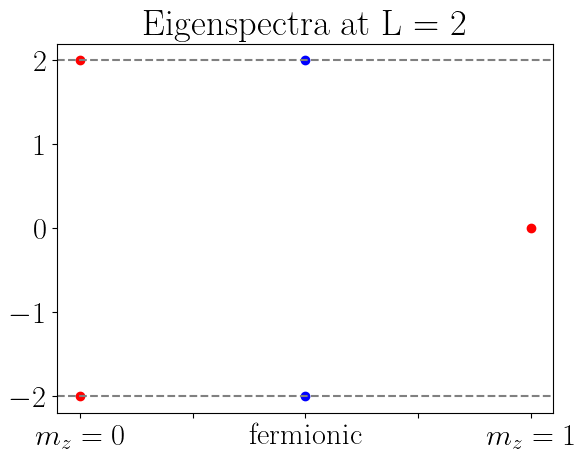

In [148]:

L = 2
J = 1
t = 2 * J

state_dict = create_statedict(L=L)
lookups = create_mag_lookups(L,state_dict)

hamil_0 = create_hamil_mag(L,J,0,lookups)
hamil_1 = create_hamil_mag(L,J,2,lookups)
hamil_f = - t * (np.diag(np.ones(L-1),1) + np.diag(np.ones(L-1),-1))


v0,_ = np.linalg.eigh(hamil_0) 
v1,_ = np.linalg.eigh(hamil_1) 
vf,_ = np.linalg.eigh(hamil_f)
for vv in v0:
    plt.scatter(0,vv,color='red')

for vv in v1:
    plt.scatter(1,vv,color='red')


for vv in vf:
    plt.scatter(1/2,vv,color='blue')
    plt.axhline(y=vv,color='grey',linestyle='--')

plt.xticks([0,0.25,0.5,0.75,1],[r'$m_z = 0$','','fermionic','',r'$m_z = 1$'])
plt.title('Eigenspectra at L = ' + str(L))

Text(0.5, 1.0, 'Eigenspectra at L = 4')

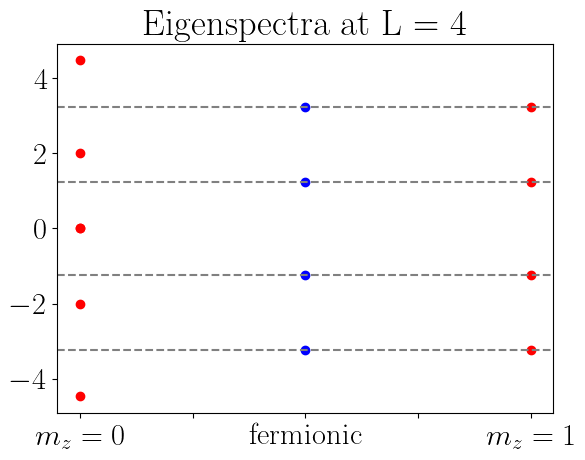

In [149]:
L = 4
J = 1
t = 2 * J

state_dict = create_statedict(L=L)
lookups = create_mag_lookups(L,state_dict)

hamil_0 = create_hamil_mag(L,J,0,lookups)
hamil_1 = create_hamil_mag(L,J,2,lookups)
hamil_f = - t * (np.diag(np.ones(L-1),1) + np.diag(np.ones(L-1),-1))


v0,_ = np.linalg.eigh(hamil_0) 
v1,_ = np.linalg.eigh(hamil_1) 
vf,_ = np.linalg.eigh(hamil_f)
for vv in v0:
    plt.scatter(0,vv,color='red')

for vv in v1:
    plt.scatter(1,vv,color='red')


for vv in vf:
    plt.scatter(1/2,vv,color='blue')
    plt.axhline(y=vv,color='grey',linestyle='--')

plt.xticks([0,0.25,0.5,0.75,1],[r'$m_z = 0$','','fermionic','',r'$m_z = 1$'])
plt.title('Eigenspectra at L = ' + str(L))

Text(0.5, 1.0, 'Eigenspectra at L = 6')

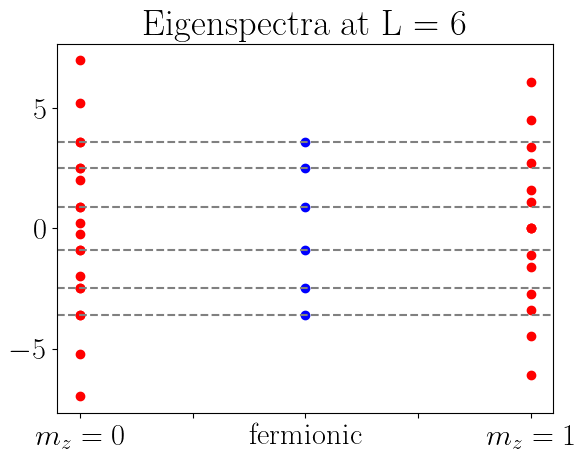

In [150]:
L = 6
J = 1
t = 2 * J

state_dict = create_statedict(L=L)
lookups = create_mag_lookups(L,state_dict)

hamil_0 = create_hamil_mag(L,J,0,lookups)
hamil_1 = create_hamil_mag(L,J,2,lookups)
hamil_f = - t * (np.diag(np.ones(L-1),1) + np.diag(np.ones(L-1),-1))


v0,_ = np.linalg.eigh(hamil_0) 
v1,_ = np.linalg.eigh(hamil_1) 
vf,_ = np.linalg.eigh(hamil_f)
for vv in v0:
    plt.scatter(0,vv,color='red')

for vv in v1:
    plt.scatter(1,vv,color='red')


for vv in vf:
    plt.scatter(1/2,vv,color='blue')
    plt.axhline(y=vv,color='grey',linestyle='--')

plt.xticks([0,0.25,0.5,0.75,1],[r'$m_z = 0$','','fermionic','',r'$m_z = 1$'])
plt.title('Eigenspectra at L = ' + str(L))

### PBC

In [158]:
# PBC now

def create_hamil_mag(L,J,mag,lookups):
    lookup = lookups[mag]
    dim = len(lookup)
    ham = np.zeros((dim,dim))
    for site in range(L):
        for i in range(dim):
            state = lookup[i]
            if state[site] != state[(site+1)%L]:
                nextstate = flipbits(state,site,(site+1)%L) # will always be in the same magnetization sector!
                mag_, j = find_ind(nextstate,lookups)
                if mag != mag_:
                    return "ERROR ERROR!!"
                ham[i,j] += 2
    return ham * J


The issue with PBC is that the boundary hopping picks up an extra phase, but this is related to models with odd number of sites. Let's show this. For $L=6$ we will just add $-t$ boundary hopping and everything will work. But, for $L=5$, we need to (first look at $m_z = 1/2,3/2$) change the sign of $-t \mapsto t$ at the boundary, as we show below.

Text(0.5, 1.0, 'PBC Eigenspectra at L = 6')

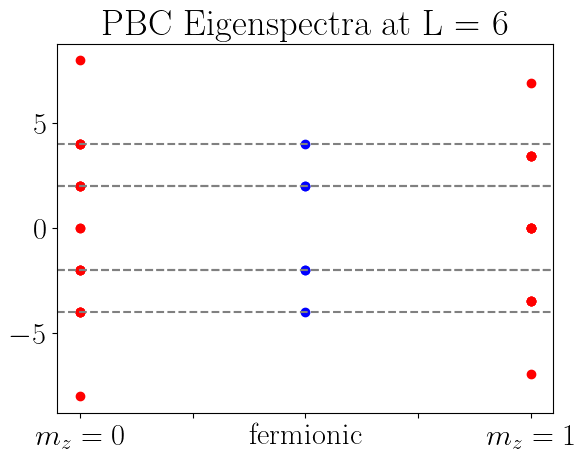

In [160]:
L = 6
J = 1
t = 2 * J

state_dict = create_statedict(L=L)
lookups = create_mag_lookups(L,state_dict)

hamil_0 = create_hamil_mag(L,J,0,lookups)
hamil_1 = create_hamil_mag(L,J,2,lookups)
hamil_f = - t * (np.diag(np.ones(L-1),1) + np.diag(np.ones(L-1),-1))
hamil_f[0,-1] = -t #normal boundary hop
hamil_f[-1,0] = -t #normal boundary hop

v0,_ = np.linalg.eigh(hamil_0) 
v1,_ = np.linalg.eigh(hamil_1) 
vf,_ = np.linalg.eigh(hamil_f)
for vv in v0:
    plt.scatter(0,vv,color='red')

for vv in v1:
    plt.scatter(1,vv,color='red')


for vv in vf:
    plt.scatter(1/2,vv,color='blue')
    plt.axhline(y=vv,color='grey',linestyle='--')

plt.xticks([0,0.25,0.5,0.75,1],[r'$m_z = 0$','','fermionic','',r'$m_z = 1$'])
plt.title('PBC Eigenspectra at L = ' + str(L))

Text(0.5, 1.0, 'PBC Eigenspectra at L = 4')

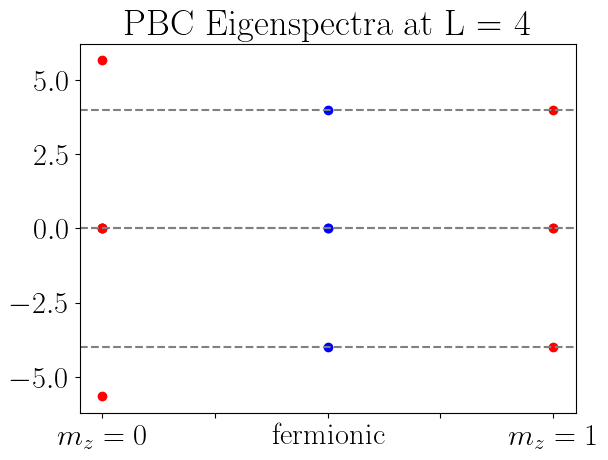

In [161]:
L = 4
J = 1
t = 2 * J

state_dict = create_statedict(L=L)
lookups = create_mag_lookups(L,state_dict)

hamil_0 = create_hamil_mag(L,J,0,lookups)
hamil_1 = create_hamil_mag(L,J,2,lookups)
hamil_f = - t * (np.diag(np.ones(L-1),1) + np.diag(np.ones(L-1),-1))
hamil_f[0,-1] = -t #normal boundary hop
hamil_f[-1,0] = -t #normal boundary hop

v0,_ = np.linalg.eigh(hamil_0) 
v1,_ = np.linalg.eigh(hamil_1) 
vf,_ = np.linalg.eigh(hamil_f)
for vv in v0:
    plt.scatter(0,vv,color='red')

for vv in v1:
    plt.scatter(1,vv,color='red')


for vv in vf:
    plt.scatter(1/2,vv,color='blue')
    plt.axhline(y=vv,color='grey',linestyle='--')

plt.xticks([0,0.25,0.5,0.75,1],[r'$m_z = 0$','','fermionic','',r'$m_z = 1$'])
plt.title('PBC Eigenspectra at L = ' + str(L))

Text(0.5, 1.0, 'PBC Eigenspectra at L = 3')

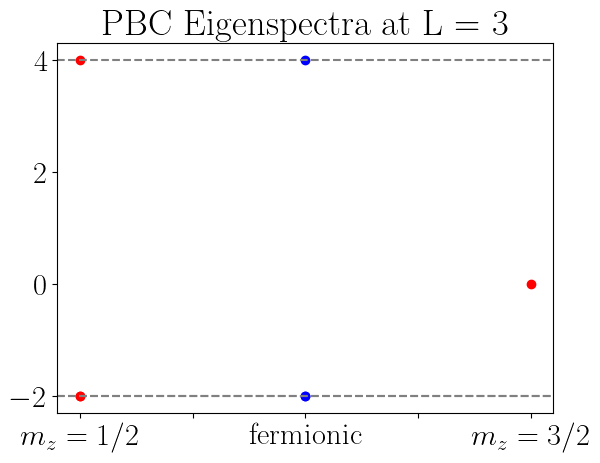

In [162]:
L = 3
J = 1
t = 2 * J

state_dict = create_statedict(L=L)
lookups = create_mag_lookups(L,state_dict)

hamil_0 = create_hamil_mag(L,J,1,lookups)
hamil_1 = create_hamil_mag(L,J,3,lookups)
hamil_f = - t * (np.diag(np.ones(L-1),1) + np.diag(np.ones(L-1),-1))
hamil_f[0,-1] = t #FLIPPED  boundary hop
hamil_f[-1,0] = t #FLIPPED  boundary hop

v0,_ = np.linalg.eigh(hamil_0) 
v1,_ = np.linalg.eigh(hamil_1) 
vf,_ = np.linalg.eigh(hamil_f)
for vv in v0:
    plt.scatter(0,vv,color='red')

for vv in v1:
    plt.scatter(1,vv,color='red')


for vv in vf:
    plt.scatter(1/2,vv,color='blue')
    plt.axhline(y=vv,color='grey',linestyle='--')

plt.xticks([0,0.25,0.5,0.75,1],[r'$m_z = 1/2$','','fermionic','',r'$m_z = 3/2$'])
plt.title('PBC Eigenspectra at L = ' + str(L))

Text(0.5, 1.0, 'PBC Eigenspectra at L = 5')

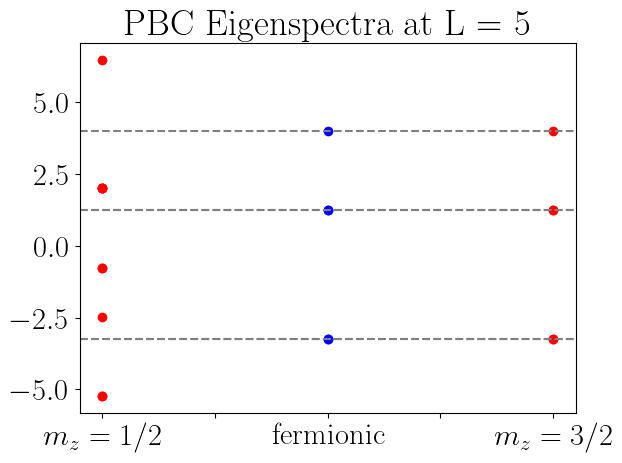

In [163]:
L = 5
J = 1
t = 2 * J

state_dict = create_statedict(L=L)
lookups = create_mag_lookups(L,state_dict)

hamil_0 = create_hamil_mag(L,J,1,lookups)
hamil_1 = create_hamil_mag(L,J,3,lookups)
hamil_f = - t * (np.diag(np.ones(L-1),1) + np.diag(np.ones(L-1),-1))
hamil_f[0,-1] = t #FLIPPED  boundary hop
hamil_f[-1,0] = t #FLIPPED  boundary hop

v0,_ = np.linalg.eigh(hamil_0) 
v1,_ = np.linalg.eigh(hamil_1) 
vf,_ = np.linalg.eigh(hamil_f)
for vv in v0:
    plt.scatter(0,vv,color='red')

for vv in v1:
    plt.scatter(1,vv,color='red')


for vv in vf:
    plt.scatter(1/2,vv,color='blue')
    plt.axhline(y=vv,color='grey',linestyle='--')

plt.xticks([0,0.25,0.5,0.75,1],[r'$m_z = 1/2$','','fermionic','',r'$m_z = 3/2$'])
plt.title('PBC Eigenspectra at L = ' + str(L))

## Problem 3.  (5 marks)

Do a Hartree-Fock study of the 2-site Fermi-Hubbard model at half-filling and quarter-filling. 
Compare the Hartree-Fock energies and states/observables with their exact values.

In [172]:
#helper functions 

# full space dictionary (strings)
def create_statedict_total(L):
    D = int(2 ** L)  
    states_dict = {}
    ctr = 0
    for i in range(D):
        for j in range(D):
            up = (bin(i)[2:])
            down = (bin(j)[2:])
            up = '0'*(L-len(up)) + up 
            down = '0'*(L-len(down)) + down 
            states_dict[ctr] = [up,down] 
            ctr += 1
    return states_dict

# spinless space dictionary (strings)
def create_statedict_single(L):
    d = 2 #local Hilbert space dimension
    D = int(d ** L) #total Hilbert space direction
    states_dict = {}
    for i in range((D)):
        state = bin(i)[2:]
        state = '0'*(L-len(state)) + state 
        states_dict[i] = state 
    return states_dict

# binary search for spinless space
def find_ind_single(state,lookup):
    #state is in binary
    low = 0
    high = len(lookup)
    mid = int(len(lookup)/2)
    while True:
        if int(lookup[mid],2) < int(state,2):
            low = mid
            mid = int((low+high)/2)
        elif int(lookup[mid],2) > int(state,2):
            high = mid
            mid = int((low+high)/2)
        elif int(lookup[mid],2) == int(state,2):
            return mid 

#binary search for full space
def find_ind_full(state,lookup):
    #state is a tuple of binaries
    low = 0
    high = len(lookup)
    mid = int(len(lookup)/2)
    while True:
        if int(''.join(lookup[mid]),2) < int(''.join(state),2):
            low = mid
            mid = int((low+high)/2)
        elif int(''.join(lookup[mid]),2) > int(''.join(state),2):
            high = mid
            mid = int((low+high)/2)
        elif int(''.join(lookup[mid]),2) == int(''.join(state),2):
            return mid 

#flip a state at specified sites
def flipbits_single(state,i,j):
    copystate = state 
    copystate = list(copystate)
    bit_i = state[i]
    bit_j = state[j]
    if bit_i == '0':
        copystate[i] = '1'
    else:
        copystate[i] = '0'
    if bit_j == '0':
        copystate[j] = '1'
    else:
        copystate[j] = '0'
    copystate = ''.join(copystate)
    return copystate

# count number of excitations between two sites
def count_excitations(state,site1,site2):
    ctr = 0
    for site in range(site1+1,site2):
        ctr += state[site]
    return ctr

# spinless hamiltonian
def singlespin_hamil(L,t):
    D = 2 ** L
    H_spin = np.zeros((D, D))
    state_dict = create_statedict_single(L)
    for site in range(L):
        nbr_site = (site + 1) % L
        for index in range(D):
            state = state_dict[index]
            nbr_index = find_ind_single(flipbits_single(state,site,nbr_site),state_dict)
            sign = (-1) ** (count_excitations(state,site,nbr_site))
            if state[site] == '0' and state[nbr_site] == '1':
                H_spin[index, nbr_index] += t * sign
            if state[site] == '1' and state[nbr_site] == '0':
                H_spin[index, nbr_index] += t * sign
    return H_spin

# helper fn: returns G.S. e-val
def return_gseval(mat):
    v, vv = np.linalg.eigh(mat)
    sorted_indices = np.argsort(v)
    sorted_eigenvalues = v[sorted_indices]
    return sorted_eigenvalues[0]


def sum_str_single(str):
    s = np.sum([int(bit) for bit in list(str)])
    return s

def create_statedict_fixedparticle(L,N=1):
    D = int(2 ** L)  
    states_dict = {}
    ctr = 0
    for i in range(D):
        for j in range(D):
            up = (bin(i)[2:])
            down = (bin(j)[2:])
            up = '0'*(L-len(up)) + up 
            down = '0'*(L-len(down)) + down 
            if(sum_str_single(up) + sum_str_single(down) == N): # fix particle number
                states_dict[ctr] = [up,down] 
                ctr += 1
    return states_dict

# only doing for from scratch approach as it is easier to fix particle number in the whole space
def full_FH_hamil_direct_fixedparticle(L,t,U,N):
    
    state_dict = create_statedict_fixedparticle(L,N)
    D = len(state_dict)
    H_full = np.zeros((D,D))
    for site in range(L-1):
        nbr_site = (site + 1) % L
        for index in range(D):
            state = state_dict[index]
            state_up = state[0]
            state_down = state[1]

            # for up
            flipped = flipbits_single(state_up,site,nbr_site)
            flipped_state = [flipped,state_down]
            
            sign = (-1) ** (count_excitations(state_up,site,nbr_site))
            if state_up[site] == '0' and state_up[nbr_site] == '1':
                nbr_index = find_ind_full(flipped_state,state_dict)
                H_full[index, nbr_index] += -t * sign
            if state_up[site] == '1' and state_up[nbr_site] == '0':
                nbr_index = find_ind_full(flipped_state,state_dict)
                H_full[index, nbr_index] += -t * sign

            # for down
            flipped = flipbits_single(state_down,site,nbr_site)
            flipped_state = [state_up,flipped]
            sign = (-1) ** (count_excitations(state_down,site,nbr_site))
            if state_down[site] == '0' and state_down[nbr_site] == '1':
                nbr_index = find_ind_full(flipped_state,state_dict)
                H_full[index, nbr_index] += -t * sign
            if state_down[site] == '1' and state_down[nbr_site] == '0':
                nbr_index = find_ind_full(flipped_state,state_dict)
                H_full[index, nbr_index] += -t * sign

            ups = list(state_up) 
            ups = [int(x) for x in ups]
            downs = list(state_down)
            downs = [int(x) for x in downs]
            ups = np.array(ups) - 0.5
            downs = np.array(downs) - 0.5
            mul = ups * downs
            H_full[index, index] = np.sum(mul) * U
    return H_full

In [173]:
L = 2
t = 1 
U = 1

FH_ED_quarter = (full_FH_hamil_direct_fixedparticle(L,t,U,N=int(2 * L / 4))) 
FH_ED_halffil = (full_FH_hamil_direct_fixedparticle(L,t,U,N=int(2 * L / 2))) 


\begin{equation}
\mathcal{H}_{MF} = - t\sum\limits_{\langle ij \rangle,\sigma}\hat{c}^\dagger_{i\sigma}\hat{c}_{j\sigma} + h.c  - \sum_{i}( \tilde{\mu}_{i,\uparrow}\hat{n}_{i,\uparrow} +  \tilde{\mu}_{i,\downarrow}\hat{n}_{i,\downarrow}),
\end{equation}
where,
\begin{equation}
\tilde{\mu}_{i,\uparrow} = \mu - U(\langle n_{i,\downarrow} \rangle -1/2), \quad \tilde{\mu}_{i,\downarrow} = \mu - U(\langle n_{i,\uparrow}\rangle-1/2)
\end{equation}

In [ ]:
def hamil_singlespin(t,mu_arr):
    L = len(mu_arr)
    h = np.diag(mu_arr) + (-t) * (np.diag(np.ones(L-1),1) + np.diag(np.ones(L-1),-1))
    return h

def hamil_fullspin(t,mu_mat):
    return np.kron([[1,0],[0,0]],hamil_singlespin(t,mu_mat[:,0])) + np.kron([[0,0],[0,1]],hamil_singlespin(t,mu_mat[:,1]))

mu = 0 
U = 1
t = 1 
L = 2

n_up_init = np.random.rand(L)
n_down_init = np.random.rand(L)
n_mat_init = np.zeros((L,2))
n_mat_init[:,0] = n_up_init 
n_mat_init[:,1] = n_down_init 
mu_init = mu - U * (n_mat_init - 1/2)

h_up = hamil_singlespin(t,mu_init[:,0])
h_down = hamil_singlespin(t,mu_init[:,1])

h = hamil_fullspin(t,mu_mat)
eigenvalues, eigenvectors = np.linalg.eig(h)
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues= eigenvalues[sorted_indices]
sorted_eigenvectors= eigenvectors[:, sorted_indices]
gs_energy_init = np.sum(sorted_eigenvalues[:L**2])

